### Introduction to the Problem: Computing π via Numerical Integration

The mathematical constant π (pi) is a fundamental element in various branches of science and engineering, representing the ratio of a circle's circumference to its diameter. An interesting and practical approach to approximate the value of π is by leveraging the concept of numerical integration. In this context, we utilize the geometrical representation of π as the area of a unit circle. To achieve an approximation, we compute the area under the curve of a quarter circle, which inherently relates to π.

#### Mathematical Formulation:
The function $$f(x) = \sqrt{1 - x^2}$$ describes the upper half of a quarter circle for $$x$$ ranging from 0 to 1. The area under this curve can be approximated using Riemann sums, a fundamental concept in numerical integration. By subdividing the interval [0, 1] into $$N$$ equal parts, each of width $$\Delta x = \frac{1}{N}$$, and summing the areas of the rectangles under the curve at these intervals, we can estimate the area of the quarter circle, and hence π. The approximation of π is given by:

$$
\frac{\pi}{4} \approx \sum_{i=0}^{N-1} \Delta x \cdot f(x_i)
$$

where $$x_i = i \cdot \Delta x$$ represents the position of each interval.

#### Computational Approach:
To compute π using the above strategy, we implement three distinct programs in Python:

1. **Serial Computation**:
   - The first version of the program calculates π without any parallelization. This involves a straightforward implementation of the Riemann sum, iteratively computing the sum of $$f(x_i)$$ for each subdivision of the interval.

2. **Parallel Computation Using Multiprocessing**:
   - To enhance performance, the second version of the program employs the `multiprocessing` library in Python. This approach divides the task among multiple processes, each calculating a segment of the total sum. This is particularly beneficial on multi-core systems, where separate processes can compute concurrently.

3. **Distributed Parallel Computation Using MPI**:
   - The third version uses the `mpi4py` library to implement distributed parallel computing. This method is well-suited for environments where computations need to be distributed across different nodes in a cluster. Each node calculates a portion of the sum, and the results are then aggregated to derive the final approximation of π.

This structured approach, progressing from a single-threaded to a multi-threaded and then to a distributed system, not only showcases the potential speed improvements but also highlights the scalability of numerical methods in computational mathematics. The aim is to efficiently approximate π, leveraging different computational strategies to cater to varying hardware capabilities and performance objectives.



In [ ]:
!pip install mpi4py

# Solutions

In [ ]:
import cProfile
import math
from multiprocessing import Pool
from mpi4py import MPI
import numpy as np
import os

In [ ]:


def f(x):
    return math.sqrt(1 - x**2)


#This function approximates π by calculating the area under the curve f(x) using a simple Riemann sum approach, without any parallel processing.
def compute_pi(N):
    delta_x = 1.0 / N
    total_sum = 0
    for i in range(N):
        xi = i * delta_x
        total_sum += f(xi)
    pi_approx = 4 * total_sum * delta_x
    return pi_approx

def partial_sum(args):
    start, end, delta_x = args
    total_sum = 0
    for i in range(start, end):
        xi = i * delta_x
        total_sum += f(xi)
    return total_sum

def compute_pi_parallel(N, num_processes):
    delta_x = 1.0 / N
    pool = Pool(processes=min(num_processes, os.cpu_count())) #A pool of worker processes is created, with the number of processes limited by either the desired number or the CPU core count.

    #The range [0, N] is divided into chunks, and each chunk is assigned to a process.
    partition_sizes = N // num_processes
    tasks = [(i * partition_sizes, (i + 1) * partition_sizes, delta_x) for i in range(num_processes)]
    results = pool.map(partial_sum, tasks)
    pool.close()
    pool.join()
    pi_approx = 4 * sum(results) * delta_x
    return pi_approx

def compute_pi_mpi(N):
    comm = MPI.COMM_WORLD
    size = comm.Get_size()
    rank = comm.Get_rank()
     #Each node computes a segment of the sum using vectorized operations via NumPy for efficiency.
    delta_x = 1.0 / N
    local_n = N // size
    local_start = rank * local_n
    local_end = (rank + 1) * local_n if rank != size - 1 else N

    # Each process computes its partial sum using NumPy for faster computation
    x_values = np.linspace(local_start * delta_x, local_end * delta_x, num=local_end-local_start, endpoint=False)
    local_sum = np.sum(np.sqrt(1 - x_values**2) * delta_x)
    total_sum = comm.reduce(local_sum, op=MPI.SUM, root=0) #The root node computes the final approximation of π by multiplying the total sum by 4.

    if rank == 0:
        pi_approx = 4 * total_sum
        return pi_approx

#Profiling   

The use of .prof files in this context provides a convenient and effective way to store and analyze the results of code profiling, making it easier to identify areas of improvement and optimize software performance.

In [ ]:
def profile_serial_computation(N):
    print("Profiling serial computation of pi...")
    cProfile.runctx('compute_pi(N)', globals(), locals(), filename="serial_profile.prof")
    pi_approx = compute_pi(N)
    print(f"Approximated value of pi: {pi_approx}")

def profile_multiprocessing_computation(N, num_processes):
    print("Profiling multiprocessing computation of pi...")
    cProfile.runctx('compute_pi_parallel(N, num_processes)', globals(), locals(), filename="multiprocessing_profile.prof")
    pi_approx = compute_pi_parallel(N, num_processes)
    print(f"Approximated value of pi using multiprocessing: {pi_approx}")

def profile_mpi_computation(N):
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()

    if rank == 0:
        print("Profiling MPI computation of pi...")
        profiler = cProfile.runctx('compute_pi_mpi(N)', globals(), locals(), filename="mpi_profile.prof")
    pi_approx_mpi = compute_pi_mpi(N)
    print(f"Approximated value of pi using mpi : {pi_approx_mpi}")

In [ ]:
if __name__ == "__main__":
    N = 1000000  # Number of intervals
    num_processes = 4  # Number of parallel processes

    # Profile serial computation
    profile_serial_computation(N)

    # Profile multiprocessing computation
    profile_multiprocessing_computation(N, num_processes)

    # Profile mpi computation
    profile_mpi_computation(N)

Profiling serial computation of pi...
Approximated value of pi: 3.141594652413976
Profiling multiprocessing computation of pi...
Approximated value of pi using multiprocessing: 3.1415946524138474
Profiling MPI computation of pi...
Approximated value of pi using mpi : 3.1415946524138105


In [ ]:
import pstats
import matplotlib.pyplot as plt

def extract_top_functions(stats, number=10):
    # This will strip the directory paths from file names in the stats
    stats.strip_dirs()
    # Sort the statistics by the total time spent in the function
    stats.sort_stats('tottime')
    # Print the top 'number' entries to the standard output and capture it
    stats.print_stats(number)

    # Create lists to store function names and total times
    functions = []
    total_times = []

    # The data is temporarily written to stdout, so we need to redirect it to capture the output
    from io import StringIO
    import sys
    old_stdout = sys.stdout
    sys.stdout = StringIO()

    stats.print_stats(number)
    output = sys.stdout.getvalue()
    sys.stdout = old_stdout

    # Process the captured output to extract function names and total times
    lines = output.split('\n')
    for line in lines[5:-3]:  # Skip the header and summary lines
        parts = line.split()
        if len(parts) >= 6:
            time = float(parts[2])
            function = ' '.join(parts[5:])
            functions.append(function)
            total_times.append(time)

    # Print the captured output
    #print(output)

    #return functions, total_times

# Load the profile data
serial_profile = pstats.Stats("serial_profile.prof")
multiprocessing_profile = pstats.Stats("multiprocessing_profile.prof")
mpi_profile = pstats.Stats("mpi_profile.prof")

# Extract top 10 functions and times for serial computation
serial_total_times = extract_top_functions(serial_profile)

# Extract top 10 functions and times for multiprocessing computation
multiprocessing_total_times = extract_top_functions(multiprocessing_profile)

# Extract top 10 functions and times for MPI computation
mpi_functions = extract_top_functions(mpi_profile)



Thu Apr 18 17:03:43 2024    serial_profile.prof

         2000004 function calls in 2.122 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  1000000    1.069    0.000    1.273    0.000 <ipython-input-67-d77614c299af>:1(f)
        1    0.849    0.849    2.122    2.122 <ipython-input-67-d77614c299af>:6(compute_pi)
  1000000    0.204    0.000    0.204    0.000 {built-in method math.sqrt}
        1    0.000    0.000    2.122    2.122 {built-in method builtins.exec}
        1    0.000    0.000    2.122    2.122 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}


Thu Apr 18 17:03:43 2024    serial_profile.prof

         2000004 function calls in 2.122 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  1000000    1.069    0.000    1.273    0.000 <ipython-input-67-d77614c299af>:1(f)
        1    0.849    0.

# Visualization of each implementation

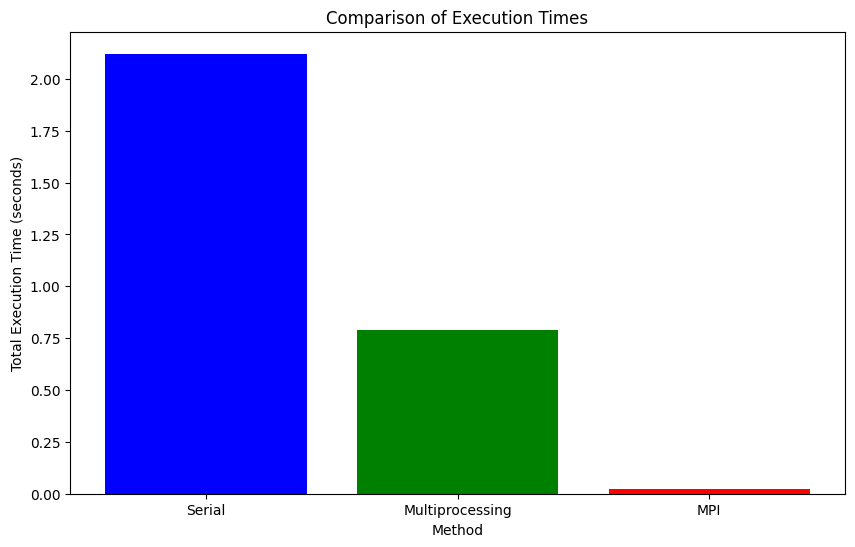

In [ ]:
serial_profile = pstats.Stats("serial_profile.prof")
multiprocessing_profile = pstats.Stats("multiprocessing_profile.prof")
mpi_profile = pstats.Stats("mpi_profile.prof")

# Function to extract total time from profile stats
def extract_total_time(profile):
    profile.strip_dirs().sort_stats('time')
    return profile.total_tt

# Extract total time for serial, multiprocessing, and mpi computation
serial_time = extract_total_time(serial_profile)
multiprocessing_time = extract_total_time(multiprocessing_profile)
mpi_time = extract_total_time(mpi_profile)

# Plotting the times
methods = ['Serial', 'Multiprocessing', 'MPI']
times = [serial_time, multiprocessing_time, mpi_time]

plt.figure(figsize=(10, 6))
plt.bar(methods, times, color=['blue', 'green', 'red'])
plt.title('Comparison of Execution Times')
plt.xlabel('Method')
plt.ylabel('Total Execution Time (seconds)')
plt.show()